# Overview
This notebook tests the quality of our two Gaussian process (GP) models (4pGP vs 5pGP) by using their hyperparameters to predict 2 activity indicators: H$\alpha$ and S-index. The GPs were fit using only RV information, so this prediction gives a view into whether the GPs are tracking stellar dynamics, rather than subsuming RV modulation due to a planet.

In order to run this notebook, you will need to download all of the python packages we use. The complete list of used packages can be found at the top of the "functions.py" file in the repository.

In [1]:
from functions import *

In [2]:
# Read in datasets
t_Butler, RV_Butler, RVerr_Butler, S_Butler, H_Butler = np.loadtxt("data/Butler_2017.txt", skiprows = 58, usecols = (1, 2, 3, 4, 5), unpack = True)

# ======== Data Cleaning and sorting
# Clean data by removing data where H-alpha = -1.0
t_cleanHa = np.zeros(0)
Ha_clean = np.zeros(0)
RV_joint_Ha = np.zeros(0)
RVerr_joint_Ha = np.zeros(0)
for i in range(len(t_Butler)):
    if H_Butler[i] != -1.0:
        t_cleanHa = np.append(t_cleanHa, t_Butler[i])
        Ha_clean = np.append(Ha_clean, H_Butler[i])
        RV_joint_Ha = np.append(RV_joint_Ha, RV_Butler[i])
        RVerr_joint_Ha = np.append(RVerr_joint_Ha, RVerr_Butler[i])

# Read in RV and S-index
inst_Bourrier  = np.loadtxt("data/Bourrier_RV.txt", dtype = str, usecols = (5), skiprows = 43)
t_Bourrier, RV_Bourrier, RVerr_Bourrier, S_Bourrier, Serr_Bourrier = np.loadtxt("data/Bourrier_RV.txt", usecols = (0, 1, 2, 3, 4), skiprows = 43, unpack = True ) # BINNED, TRENDED 
t_Bourrier = t_Bourrier + 2400000.0 # Shift to BJD

# Sort by time index
t_Bourrier, RV_Bourrier, RVerr_Bourrier, inst_Bourrier = sort_time(t_Bourrier, RV_Bourrier, RVerr_Bourrier, inst_Bourrier)
t_Bourrier_S, S_Bourrier, Serr_Bourrier, inst_Bourrier_S = sort_time(t_Bourrier, S_Bourrier, Serr_Bourrier, inst_Bourrier)

Smat = np.loadtxt("data/Bourrier_RV.txt", usecols = (0, 1, 2, 3, 4), skiprows = 43, unpack = False ) # BINNED, TRENDED 
S_inst = np.loadtxt("data/Bourrier_RV.txt", dtype = str, usecols = (5), skiprows = 43, unpack = False ) # BINNED, TRENDED 
KECKmask = S_inst == "KECK"

Sindex = Smat[KECKmask, 3]
Serr = Smat[KECKmask, 4] 
t_S = Smat[KECKmask, 0]-np.min(Smat[KECKmask, 0]) 
RV_S = Smat[KECKmask, 1] 
RVerr_S = Smat[KECKmask, 2]

# New variables and changes for activity analysis.
t_Ha = t_cleanHa-t_cleanHa[0]
Ha = Ha_clean

# S-index GP model

In [3]:
# SET UP GP KERNELS
#================================
time = t_S 
ind = Sindex 
ind_err = Serr
N = len(time)
new_times = np.linspace(np.min(time), np.max(time), N)

amp_S_guess = 0.02
amp_H_guess = 0.0002 

metric_guess = 16.5 
decor_guess = 3500**2 # [days]^2

gamma_guess = 0.2
period_guess = 1./f_mag # [days]

# Parameter order: ln(amplitude), ln(metric^2), gamma, ln(period)
guess_pars_S = [np.log(amp_S_guess), np.log(decor_guess), gamma_guess, np.log(period_guess)]
guess_pars_H = [np.log(amp_H_guess), np.log(decor_guess), gamma_guess, np.log(period_guess)]

k_S_exp2 = np.std(ind) * kernels.ExpSquaredKernel(metric = (metric_guess))
k_S_per = kernels.ExpSine2Kernel(gamma = gamma_guess, log_period = np.log(period_guess))
k_S = k_S_exp2 * k_S_per
#================================

# Initialize the Gaussian processes
gp_S = george.GP(k_S, fit_kernel = True, mean = np.mean(ind))
gp_S.set_parameter_vector(guess_pars_S)

# You need to compute GPs before using them.
gp_S.compute(time, ind_err) 

# H$\alpha$ GP model

In [4]:
# SET UP GP KERNELS
#================================
time = t_cleanHa-t_cleanHa[0] 
ind = Ha_clean 

new_times = np.linspace(np.min(time), np.max(time), (len(time))) 

metric_guess = 16.8 
gamma_guess = 0.2
period_guess = np.exp(8.4) 

guess_pars = [np.log(np.exp(4.0)), metric_guess, gamma_guess, np.log(period_guess)]

k_H_exp2 = np.std(ind) * kernels.ExpSquaredKernel(metric = (metric_guess))
k_H_per = kernels.ExpSine2Kernel(gamma = 0.00001, log_period = np.log(period_guess))
k_H = k_H_exp2 * k_H_per
#================================

# Initialize the Gaussian processes
gp_H = george.GP(k_H, fit_kernel = True, mean = np.mean(ind))

# You need to compute both GPs before using them.
gp_H.compute(time) # Ha values from Butler et al. (2017) do not have errorbars

# Project the GPs from the 4-planet and 5-planet models onto S-index and H$\alpha$
Use the best-fit period and evolution timescales found via the global MCMC fit of each model to predict both activity indicators. How well can we do using GPs only informed by RVs?

In [5]:
# Read in best-fit GP params
param_4pGP = np.loadtxt('caviness/55Cnc_4pGP_MCMC_param_alpha_200000000_newamp.txt')[31-4:]
param_5pGP = np.loadtxt("caviness/55Cnc_5pGP_MCMC_param_alpha_3000000000_newamp.txt")[36-4:]

4 planet GP model on S-index:  [-2.78142767 17.02510106  0.1         8.51215934]
4 planet GP model on H-alpha:  [-7.67347315 17.02510106  0.1         8.51215934]
5 planet GP model on S-index:  [-2.78142767 15.99786227  0.1         8.52779665]
5 planet GP model on H-alpha:  [-7.67347315 15.99786227  0.1         8.52779665]


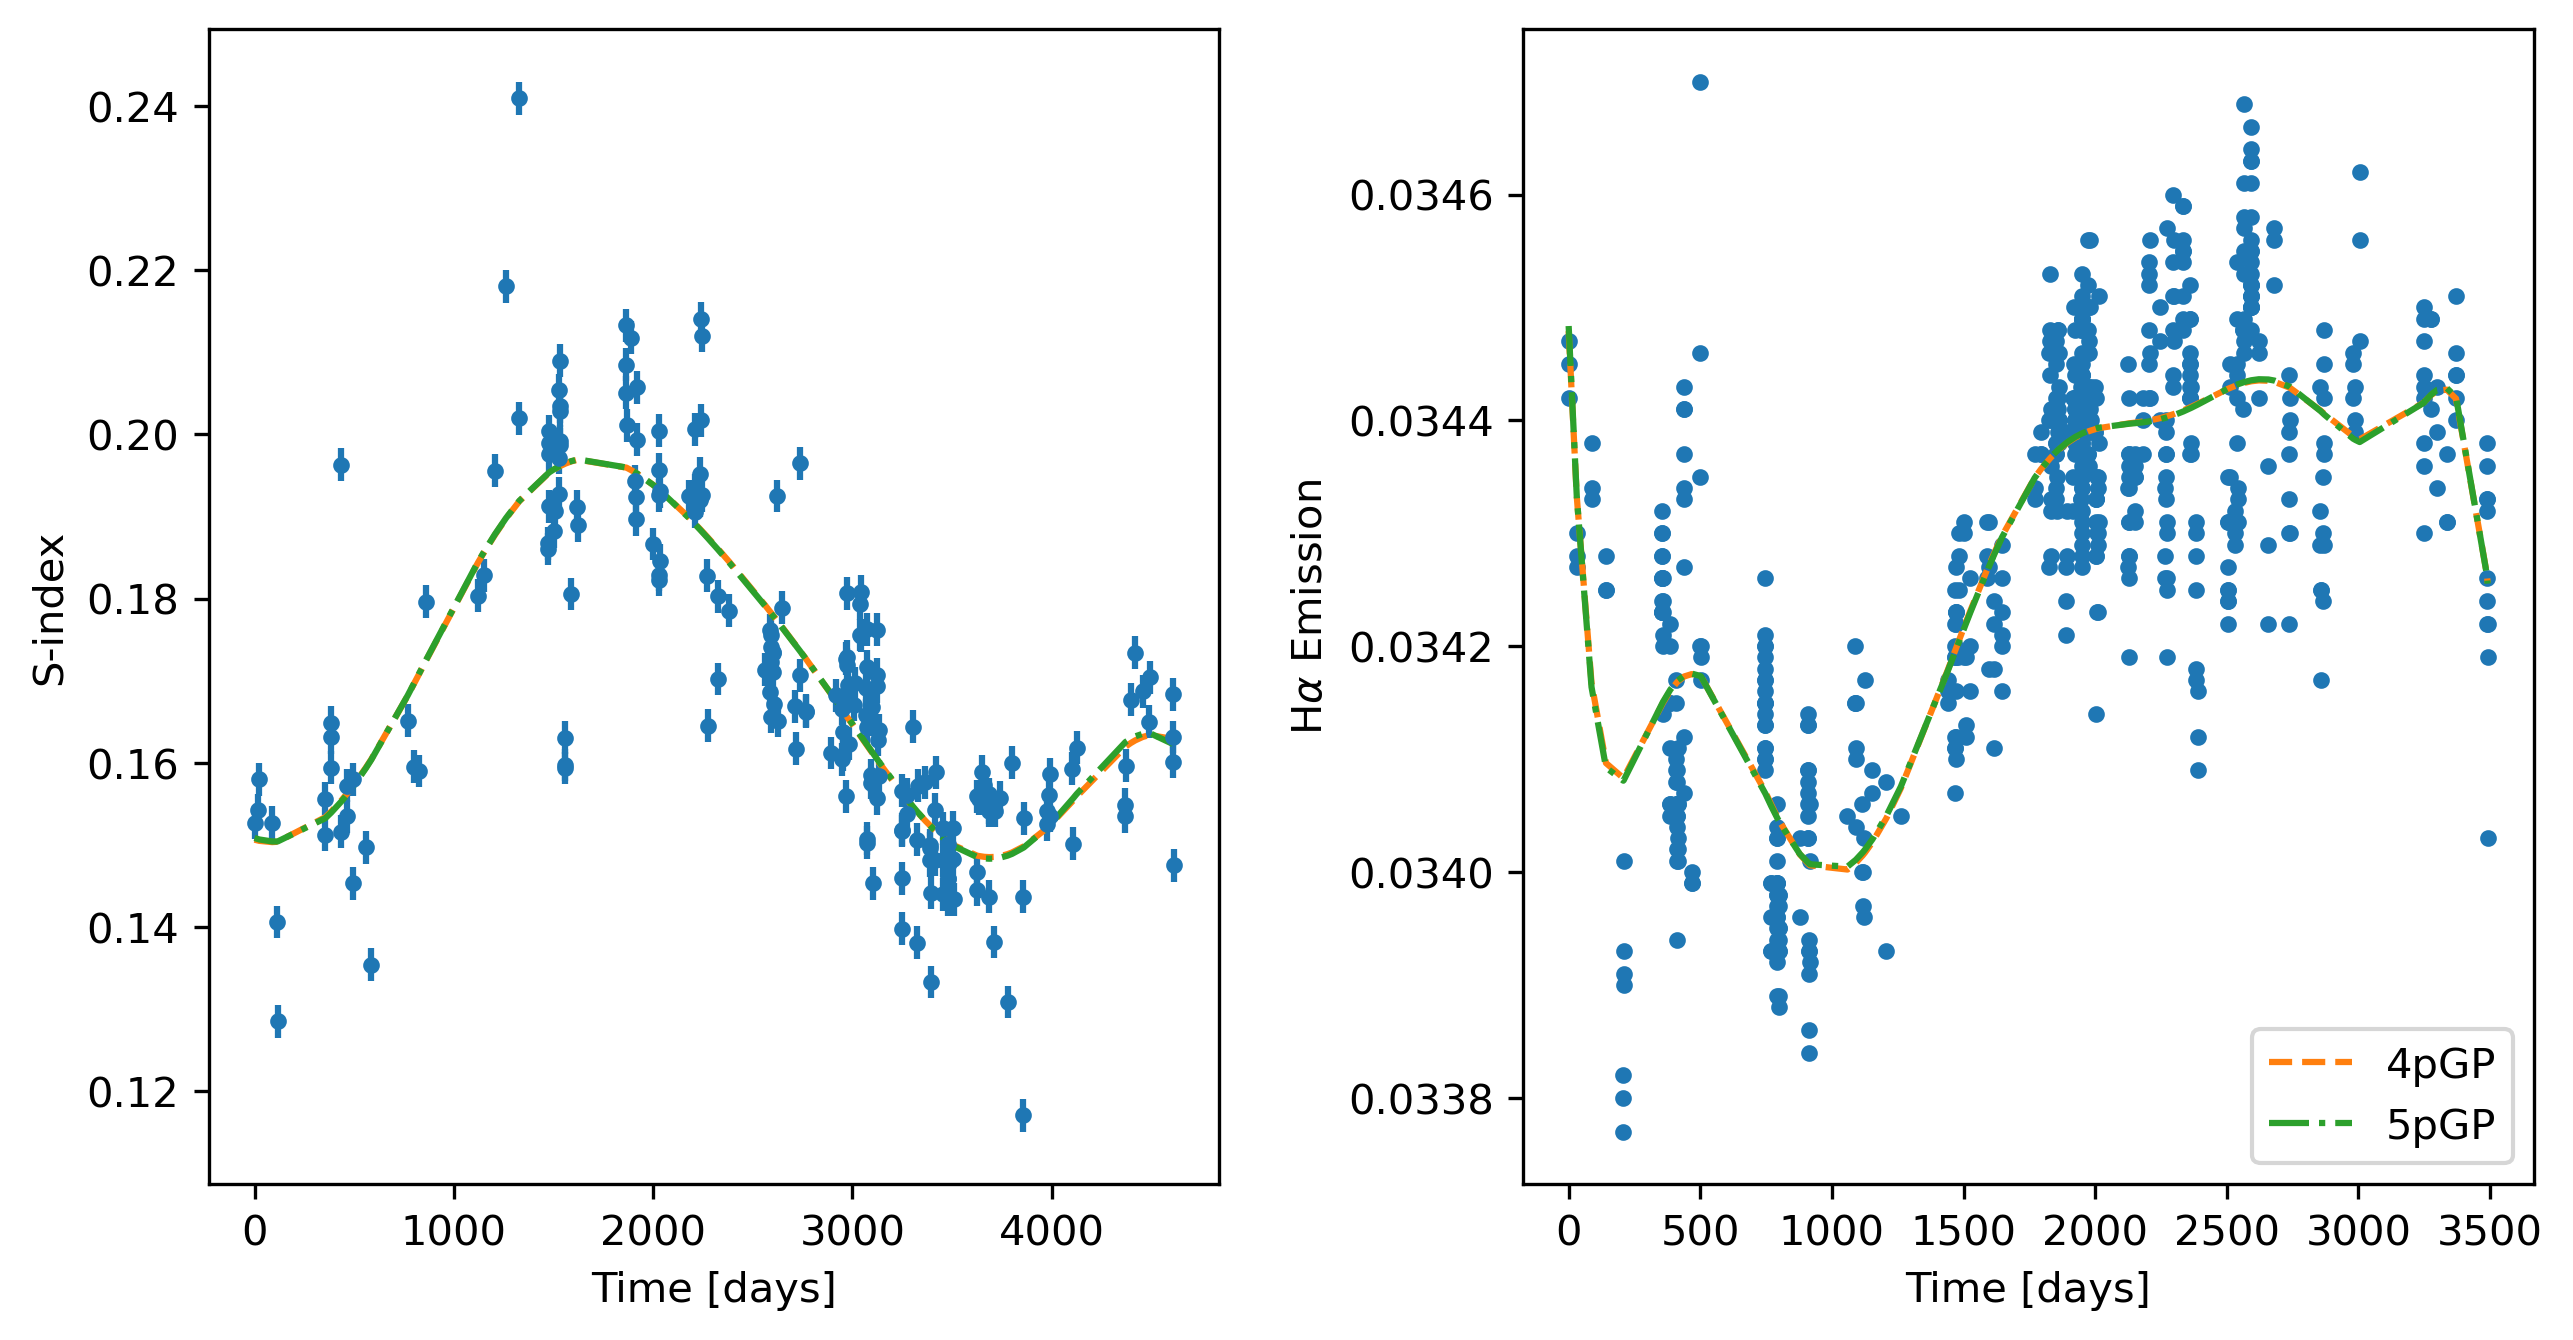

In [6]:
# Set GP hyperparameters to the best fit values found via MCMC 
param_H_4pGP = np.zeros(4)
param_S_4pGP = np.zeros(4)
param_H_5pGP = np.zeros(4)
param_S_5pGP = np.zeros(4)

# Initialize amplitudes
param_H_4pGP[0] = np.log(0.5*(np.max(Ha_clean)-np.min(Ha_clean))) 
param_H_5pGP[0] = np.log(0.5*(np.max(Ha_clean)-np.min(Ha_clean))) 
param_S_4pGP[0] = np.log(0.5*(np.max(Sindex)-np.min(Sindex)))
param_S_5pGP[0] = np.log(0.5*(np.max(Sindex)-np.min(Sindex)))

# Set the period and evolution scale to the best fit MCMC values in each model
param_H_4pGP[1] = param_4pGP[1]
param_H_5pGP[1] = param_5pGP[1]
param_S_4pGP[1] = param_4pGP[1]
param_S_5pGP[1] = param_5pGP[1]
# Period:
param_H_4pGP[3] = param_4pGP[3]
param_H_5pGP[3] = param_5pGP[3]
param_S_4pGP[3] = param_4pGP[3]
param_S_5pGP[3] = param_5pGP[3]

# Lower the evolutionary timescale in accordance with the shorter observation campaigns for the acitivity indicators
# George takes gamma instead of the correlation scale. 
param_H_4pGP[2] = 0.1
param_H_5pGP[2] = 0.1
param_S_4pGP[2] = 0.1
param_S_5pGP[2] = 0.1

gp_S.set_parameter_vector(param_S_4pGP)
print("4 planet GP model on S-index: ", gp_S.get_parameter_vector())

GP_Spred_4pGP, pred_Svar_4pGP = gp_S.predict(Sindex, t_S, return_var = True)

gp_H.set_parameter_vector(param_H_4pGP)
print("4 planet GP model on H-alpha: ", gp_H.get_parameter_vector())
GP_Hpred_4pGP, pred_Hvar_4pGP = gp_H.predict(Ha_clean, t_cleanHa-t_cleanHa[0], return_var = True)

gp_S.set_parameter_vector(param_S_5pGP) 
print("5 planet GP model on S-index: ", gp_S.get_parameter_vector())
GP_Spred_5pGP, pred_Svar_5pGP = gp_S.predict(Sindex, t_S, return_var = True)

gp_H.set_parameter_vector(param_H_5pGP)
print("5 planet GP model on H-alpha: ", gp_H.get_parameter_vector())
GP_Hpred_5pGP, pred_Hvar_5pGP = gp_H.predict(Ha_clean, t_cleanHa-t_cleanHa[0], return_var = True)

# Project the 4pGP and 5pGPs onto H-alpha and S-index to see agreement
plt.figure(figsize = (10, 5), dpi = 300.)
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
ax1.errorbar(t_S, Sindex, yerr = Serr, fmt = '.')
ax1.plot(t_S, GP_Spred_4pGP, '--', label = "4p GP")
ax1.plot(t_S, GP_Spred_5pGP, '-.', label = "5p GP")
ax1.set_xlabel("Time [days]")
ax1.set_ylabel("S-index")

ax2.plot(t_cleanHa-t_cleanHa[0], Ha_clean,  '.')
ax2.plot(t_cleanHa-t_cleanHa[0], GP_Hpred_4pGP, '--', label = "4pGP")
ax2.plot(t_cleanHa-t_cleanHa[0], GP_Hpred_5pGP, '-.', label = "5pGP")
ax2.legend(loc = 0)
ax2.set_xlabel("Time [days]")
ax2.set_ylabel(r"H$\alpha$ Emission")
plt.subplots_adjust(wspace = 0.3)
plt.show()